In [6]:
%cd ~/programs/critic-llm/
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)

/home/nicholas/programs/critic-llm


In [7]:
from critic import load_llama_corrector
corrector = load_llama_corrector()

llama_model_loader: loaded meta data with 29 key-value pairs and 147 tensors from models/llama-3.2-1b-q4_k_m.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Llama 3.2 1B
llama_model_loader: - kv   3:                           general.basename str              = Llama-3.2
llama_model_loader: - kv   4:                         general.size_label str              = 1B
llama_model_loader: - kv   5:                            general.license str              = llama3.2
llama_model_loader: - kv   6:                               general.tags arr[str,6]       = ["facebook", "meta", "pytorch", "llam...
llama_model_loader: - kv   7:

In [8]:
from critic.kbd_model import KbdModel
from scipy.special import logit

        # self.tilt = self.add_weight((), initializer="zeros")
        # self.aspect_ratio = self.add_weight((), initializer="zeros")
        # # omission, insertion, substitute, transpose
        # self.category_logits = self.add_weight((4,), initializer="normal")
        # self.two_hand_logit = self.add_weight((), initializer="zeros")
        # self.vowel_logit = self.add_weight((), initializer="zeros")
        # self.scale = self.add_weight((), initializer="zeros")
        # self.power = self.add_weight(
        #     (),
        #     initializer=lambda shape, dtype: 2
        #     * keras.initializers.Ones()(shape, dtype),
        # )

old_mod = KbdModel()
old_mod.load_weights('models/kbd_model.weights.h5')

old_mod.get_weights()

old_mod.set_weights([
    np.array(0.0),
    logit(np.sqrt(8.13) / (np.sqrt(8.13) + np.sqrt(0.66))),
    np.log(np.array([0.17, 0.15, 0.52, 0.15])),
    np.array(1.13),
    np.array(0.),
    np.array(0.),
    np.array(np.hypot(np.sqrt(8.13), np.sqrt(0.66)))
])

In [9]:
df = pd.read_feather('precomputed/all_typos.feather')
print(df.shape)
df.head()

(35551, 12)


,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char
0,omission,False,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,19,NaN,Can you help get this,s,i
1,substitute,True,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,20,19.0,Can you help get this c,␣,s
2,omission,False,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,t,
3,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,␣,t
4,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,26,NaN,Doctors gave him 10 years to,,t


In [10]:
last = df.groupby('p').last().reset_index()
prompts = last['p']
text = last['t']

def clean(series):
    return series.str.replace('␣', '').str.replace('¬', '')

last['p_clean'] = clean(prompts)
last['t_clean'] = clean(text)


clean = last[last['p_clean'].str.lower() != last['t_clean'].str.lower()][['p_clean', 't_clean']]

valid = clean[clean['p_clean'].str.count(' ') == clean['t_clean'].str.count(' ')]
valid.iloc[::100]

/tmp/ipykernel_1805293/3213324013.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last = df.groupby('p').last().reset_index()


,p_clean,t_clean
0,1.5 million visitors will flood Atlanta each d...,1.5 million visitors will flood Atlanta each d...
292,Are you getting all the information you need?,Are you gettig all the information you need?
550,Brady only has five catches this season.,Brady only has five catches this seaon.
799,Can you try this again?,Can ou tjry rhis again?
1036,Disney was great and I've been to eight baseba...,Disney was great and I;ve been to eight baseba...
1352,"Even if it were approved, Clinton could veto t...","Evn if it were approved, Clinton could veto th..."
1675,"He can be explosive, but he is also erratic.",he can be explosive ut he is also erratic
1974,He said he would resist all the pressure of ti...,He said he would resist all the presure of tim...
2263,"However, he is expected to play in this week's...","However, he is expected to play n this week's ..."
2545,I cannot figure out where these prices are com...,I cannot figure out where these prices re comi...


In [21]:
import pickle
from dataclasses import dataclass
from tqdm import tqdm
from string import ascii_lowercase

from critic.corrector import Corrections
from critic.kbd_layout import QWERTY
from critic.simple_corrector import SimpleCorrector, UniformCorrector

@dataclass
class CorrectionResult:
    true: str
    typed: str
    corrs: Corrections
    context: str


def evaluate(corrector, path):
    results = []
    data = valid[::20]
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        corrector.clear_context()
        context = ''

        p_words = row['p_clean'].split(' ')
        t_words = row['t_clean'].split(' ')

        for true, typed in zip(p_words, t_words):
            if all(c.lower() in ascii_lowercase for c in true + typed):
                corrs = corrector.correct(typed)
                results.append(CorrectionResult(true, typed, corrs, context))
                corrector.push_word(true)
                context += true + ' '

    print(len(results))

    with open(f'results/{path}.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results


# evaluate(corrector, 'optimized_probs')
kbd_results = evaluate(corrector.base, 'kbd_probs')
# corrector.base.model = old_mod
# evaluate(corrector, 'old_probs')

# simple = SimpleCorrector()
# simple_results = evaluate(simple, 'simple_probs')

100%|██████████| 179/179 [09:48<00:00,  3.29s/it]

1229


In [32]:
from dataclasses import dataclass
import os
from typing import Any, Sequence

from critic.kbd_layout import QWERTY

os.environ["KERAS_BACKEND"] = "jax"

import keras
from keras import layers as nn
from keras import ops
import jax
import jax.numpy as jnp
from typing import Sequence, Any
from keras import ops
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
@dataclass
class MultivariateNormal:
    loc: Sequence[Any]
    cov: Sequence[Any]
    
    def log_prob(self, x0):

        def f(x):
            loc, cov = self.loc, self.cov
            y = (x - loc).T @ ops.inv(cov) @ (x - loc)
            Z = (2 * jnp.pi) ** (0.5 * cov.shape[0]) * ops.abs(ops.det(cov)) ** 0.5
            return ops.log(ops.exp(-0.5 * y) / Z)
        
        return jax.vmap(f)(x0)

    
x = ops.sigmoid(2.1)
y = 1 - x

cov = ops.diag([x, y]) * ops.exp(1.1)

cost = ops.cos(0.5)
sint = ops.sin(0.5)

R = ops.convert_to_tensor([[cost, -sint], [sint, cost]])
# R = torch.stack([cost, -sint, sint, cost]).reshape(2, 2)

loc = ops.zeros([2], dtype="float32")
cov=ops.matmul(ops.matmul(R, cov), R.T)

# dist = tfd.MultivariateNormalFullCovariance(
#     loc=ops.zeros([2], dtype="float32"),
#     covariance_matrix=ops.matmul(ops.matmul(R, cov), R.T),
# )
d1 = MultivariateNormal(
    loc=loc,
    cov=cov
)

d2 = tfd.MultivariateNormalFullCovariance(loc=loc, covariance_matrix=cov)

x = jnp.array([[0.1, 0.3], [0.3, 0.5]])

d1.log_prob(x)

Array([-1.853115 , -1.9523523], dtype=float32)

In [33]:
d2.log_prob(x)

Array([-1.8531148, -1.9523523], dtype=float32)

In [15]:
from typing import Sequence


def grade(res: CorrectionResult):
    corrs = res.corrs.as_series().sort_values(ascending=False)
    if res.true in corrs.index:
        data = {
            'prob': corrs[res.true],
            'rank': list(corrs.index).index(res.true) + 1
        }
    else:
        data = {
            'prob': 0,
            'rank': 20
        }

    data['error'] = res.true != res.typed
    data['correct'] = res.true == corrs.index[0]

    return data

def grade_all(results: Sequence[CorrectionResult]):
    return pd.DataFrame([grade(res) for res in results])

simple_df = grade_all(simple_results)
simple_df

,prob,rank,error,correct
0,0.211635,1,False,True
1,0.253073,1,False,True
2,0.205793,1,False,True
3,0.271056,1,False,True
4,0.338753,1,False,True
...,...,...,...,...
1224,0.204607,1,False,True
1225,0.204607,1,False,True
1226,0.204607,1,False,True
1227,0.200004,1,False,True


In [20]:
ranks = simple_df['rank']

((ranks > 5) & (ranks < 20)).mean()

np.float64(0.04068348250610252)

In [ ]:
grade_dfs = []

for path, name in [
    ('old_probs', 'Old'),
    ('optimized_probs', 'New'),
    ('lm_probs', 'LM Only')
]:
    with open(f'results/{path}.pkl', 'rb') as f:
        results = pickle.load(f)
        grades = grade_all(results)
        grades['model'] = name
        grade_dfs.append(grades)

grades = pd.concat(grade_dfs, axis=0).reset_index(drop=True)

display(pd.crosstab(grades['error'], grades['correct']))

display(grades.groupby('model').mean().round(2)[['prob', 'rank', 'correct']])
display(grades.query('error').groupby('model').mean().round(2)[['prob', 'rank', 'correct']])

with sns.plotting_context('talk'):
    g = sns.displot(grades, x='prob', row='model', aspect=2)
    g.set_titles('{row_name}')
    for ax in g.axes.flatten():
        rp.ylabel_top(ax=ax)

    g = sns.displot(grades, x='rank', discrete=True, y='model')
    for ax in g.axes.flatten():
        rp.ylabel_top(ax=ax)

/home/nmiklaucic/miniconda3/envs/llm/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


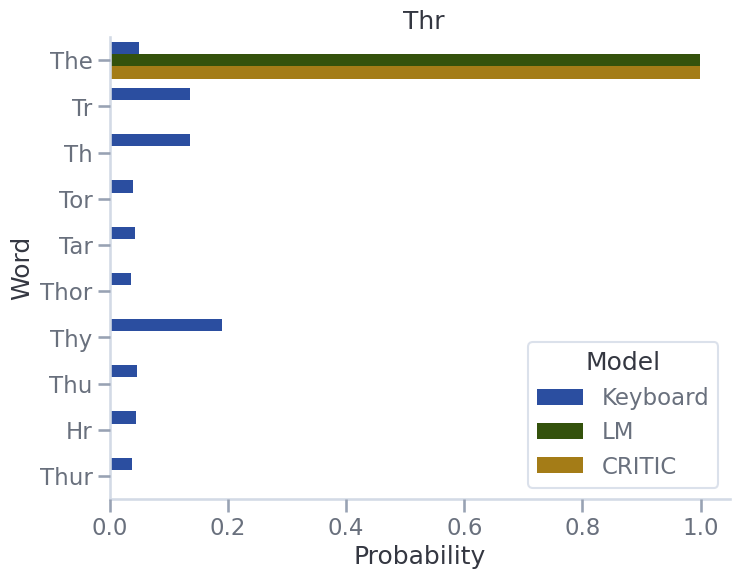

In [8]:
from copy import deepcopy


corrector = load_combo_corrector()


kbd_corrector = corrector.base
lm_corrector = load_combo_corrector()
lm_corrector.base = UniformCorrector()


context = ''
word = 'Thr'
# context = 'The coverage about me in the paper'
# word = 'gas'


corrector.push_words(context)
lm_corrector.push_words(context)

corrs = corrector.correct(word).as_series()
kbd_corrs = kbd_corrector.correct(word).as_series()
lm_corrs = lm_corrector.correct(word).as_series()


df = pd.DataFrame({'Keyboard': kbd_corrs, 'LM': lm_corrs, 'CRITIC': corrs}).reset_index(names='Word').sort_values('CRITIC', ascending=False).iloc[:10].melt(var_name='Model', value_name='Probability', id_vars=['Word'])

with sns.plotting_context('talk'):
    sns.barplot(df, x='Probability', y='Word', orient='h', hue='Model')
    plt.gca().set_title(f'{context} {word}')